In [1]:
import os
import numpy as np
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns

from utils.measure import get_angle, get_ratio 
from utils.visualization import show_angle_ratio

In [2]:
predictions = pd.read_csv("dataset/infer_both_model_efficientnet-b3_size_512.csv")
print(predictions.shape)
predictions.head()

(93, 3)


,#filename,pred_coords,target_coords
0,patient11187_study1_negative_image3.png,"[315.79998779296875, 180.8000030517578, 297.79...","[319.0, 181.63999938964844, 295.0, 130.4400024..."
1,patient11236_study1_negative_image2.png,"[219.39999389648438, 211.8000030517578, 243.0,...","[219.8800048828125, 210.0, 242.91000366210938,..."
2,patient11236_study1_negative_image3.png,"[234.60000610351562, 252.1999969482422, 255.60...","[235.0, 251.38999938964844, 256.0, 164.8999938..."
3,patient11255_study1_negative_image2.png,"[267.0, 217.0, 271.0, 161.60000610351562, 333....","[268.57000732421875, 218.0, 270.8599853515625,..."
4,patient11267_study2_negative_image2.png,"[137.39999389648438, 237.8000030517578, 157.19...","[139.0, 240.8699951171875, 158.0, 161.41999816..."


In [3]:
pred_coords = [np.array(literal_eval(val)).reshape(-1, 2) for val in predictions['pred_coords'].values]
target_coords = [np.array(literal_eval(val)).reshape(-1, 2) for val in predictions['target_coords'].values]
pred_coords = np.stack(pred_coords)
target_coords = np.stack(target_coords)

In [4]:
def get_angle_ratio_isinf(points):
    angle = get_angle(points[0], points[1], points[2])
    output = get_ratio(points)
    AI_ratio, is_inf = output['AI_ratio'], output['is_inf']
    return angle, AI_ratio, is_inf

In [5]:
def get_results(coords):    
    angles = []
    ratios = []
    is_infs = []
    for points in coords:
        angle, ratio, is_inf = get_angle_ratio_isinf(points)
        angles.append(angle)
        ratios.append(ratio)
        is_infs.append(is_inf)
    
    return np.array(angles), np.array(ratios), np.array(is_infs)

In [6]:
pred_angles, pred_ratios, pred_is_infs = get_results(pred_coords)
target_angles, target_ratios, target_is_infs = get_results(target_coords)

c:\Moein\AI\Code\MURA-Shoulder\utils\measure.py:34: RuntimeWarning: divide by zero encountered in double_scalars
  slope = (y2 - y1) / (x2 - x1)


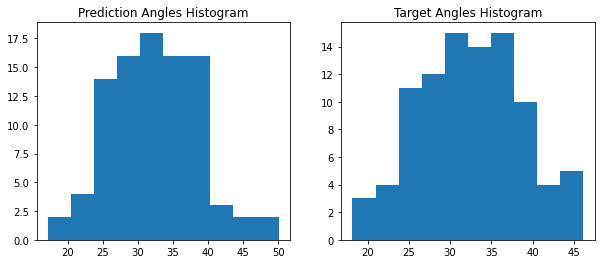

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.hist(pred_angles)
ax1.set_title("Prediction Angles Histogram")
ax2.hist(target_angles)
ax2.set_title("Target Angles Histogram")
plt.show()

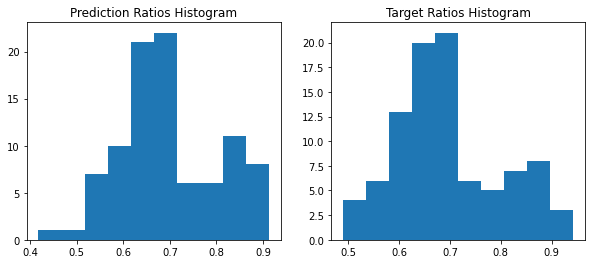

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.hist(pred_ratios)
ax1.set_title("Prediction Ratios Histogram")
ax2.hist(target_ratios)
ax2.set_title("Target Ratios Histogram")
plt.show()

In [9]:
all_results = pd.DataFrame({
    'pred_angles': pred_angles,
    'target_angles': target_angles,
    'angle_error': pred_angles - target_angles,
    'pred_ratios': pred_ratios,
    'target_ratios': target_ratios,
    'ratio_error': pred_ratios - target_ratios,
    'pred_is_infs': pred_is_infs,
    'target_is_infs': target_is_infs
})

In [10]:
all_results[['pred_angles', 'target_angles']].corr()

,pred_angles,target_angles
pred_angles,1.000000,0.938714
target_angles,0.938714,1.000000


In [11]:
 all_results[['pred_ratios', 'target_ratios']].corr()

,pred_ratios,target_ratios
pred_ratios,1.000000,0.938996
target_ratios,0.938996,1.000000


In [12]:
all_results.describe()

,pred_angles,target_angles,angle_error,pred_ratios,target_ratios,ratio_error
count,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000
mean,32.346581,32.542951,-0.196370,0.695210,0.694147,0.001063
std,6.309686,6.285058,2.204870,0.105749,0.105837,0.036953
min,17.212965,18.162209,-4.493657,0.418060,0.489606,-0.079778
25%,28.138043,27.811412,-1.805876,0.634261,0.628117,-0.020346
50%,33.025807,32.539066,-0.328755,0.675585,0.674806,-0.002657
75%,36.197690,37.349831,0.764074,0.770444,0.752214,0.019830
max,50.063976,46.123718,6.435609,0.912790,0.942849,0.114388


In [13]:
print(f"Angle Mean Absolute Error: {all_results['angle_error'].abs().mean().round(4)}")
print(f"Angle Root Mean Squared Error: {np.sqrt((all_results['angle_error'].to_numpy() ** 2).mean()).round(4)}")
print(f"Angle Min Error: {all_results['angle_error'].abs().min().round(4)} | Angle Max Error: {all_results['angle_error'].abs().max().round(4)}")
print("")
print(f"Ratio Mean Absolute Error: {all_results['ratio_error'].abs().mean().round(4)}")
print(f"Ratio Root Mean Squared Error: {np.sqrt((all_results['ratio_error'].to_numpy() ** 2).mean()).round(4)}")
print(f"Ratio Min Error: {all_results['ratio_error'].abs().min().round(4)} | Ratio Max Error: {all_results['ratio_error'].abs().max().round(4)}")


Angle Mean Absolute Error: 1.6848
Angle Root Mean Squared Error: 2.2018
Angle Min Error: 0.0017 | Angle Max Error: 6.4356

Ratio Mean Absolute Error: 0.0275
Ratio Root Mean Squared Error: 0.0368
Ratio Min Error: 0.0002 | Ratio Max Error: 0.1144


In [15]:
sorted([5, 2, 3, 6])

[2, 3, 5, 6]

## Confidence Interval

In [24]:
def get_CI(data, confidence, num_samples=100_000):
    samples = []
    for _ in range(num_samples):
        sample = np.random.choice(data, size=data.shape[0], replace=True)
        samples.append(sample)

    stats = sorted([sample.mean() for sample in samples])
    start_idx = (confidence / 2.0) * num_samples
    end_idx = (1 - confidence / 2.0) * num_samples
    interval_start = stats[int(start_idx)]
    interval_end = stats[int(end_idx)]
    return interval_start, interval_end

In [30]:
all_results['ratio_error'].to_numpy() ** 2

array([6.36450093e-03, 1.28861590e-04, 6.76409611e-04, 3.63211677e-04,
       4.01780106e-06, 5.82398451e-07, 8.80622956e-05, 1.01066069e-03,
       2.46371831e-04, 4.14425005e-03, 4.65956589e-04, 2.56638351e-03,
       4.26985833e-04, 1.63539862e-05, 1.91971218e-04, 4.57237185e-04,
       5.07439399e-04, 6.52553601e-05, 1.35936374e-04, 7.04155727e-04,
       2.50664520e-03, 9.55147823e-07, 6.02363952e-04, 1.30846992e-02,
       4.15895005e-08, 6.11645921e-04, 3.83256298e-03, 1.64390786e-03,
       8.18502298e-07, 5.64549842e-03, 9.48283208e-05, 3.25053446e-03,
       3.45260602e-05, 1.43851838e-03, 4.47503414e-03, 1.07583164e-03,
       3.02604740e-03, 7.65626904e-05, 1.09468092e-05, 1.46538690e-03,
       1.98842128e-04, 3.90498716e-05, 2.31292339e-03, 3.79100415e-04,
       7.20563283e-06, 1.17660109e-04, 7.76417861e-04, 2.87109460e-04,
       4.05371433e-04, 5.84881958e-03, 6.15572820e-04, 2.80824604e-03,
       3.46183216e-03, 3.95168458e-06, 8.98786705e-05, 7.33583716e-03,
      

In [35]:
angle_errors = all_results['angle_error'].abs().values
interval_start, interval_end = get_CI(angle_errors, 0.05)
print(f"CI 95% ({interval_start:.3f}, {interval_end:.3f}) Angle Error")


ratio_errors = all_results['ratio_error'].abs().values
interval_start, interval_end = get_CI(ratio_errors, 0.05)
print(f"CI 95% ({interval_start:.3f}, {interval_end:.3f}) Ratio Error")

CI 95% (1.403, 1.981) Angle Error
CI 95% (0.023, 0.033) Ratio Error


In [36]:
angle_errors = all_results['angle_error'].to_numpy() ** 2
interval_start, interval_end = get_CI(angle_errors, 0.05)
print(f"CI 95% ({np.sqrt(interval_start):.3f}, {np.sqrt(interval_end):.3f}) Angle Error")


ratio_errors = all_results['ratio_error'].to_numpy() ** 2
interval_start, interval_end = get_CI(ratio_errors, 0.05)
print(f"CI 95% ({np.sqrt(interval_start):.3f}, {np.sqrt(interval_end):.3f}) Ratio Error")

CI 95% (1.850, 2.544) Angle Error
CI 95% (0.030, 0.043) Ratio Error


In [14]:
all_results['angle_error'].abs().sort_values(ascending=False)[:10]

91    6.435609
55    5.512690
23    5.474802
36    4.923579
11    4.618486
9     4.493657
92    4.342819
28    4.115414
0     3.987981
64    3.923309
Name: angle_error, dtype: float64

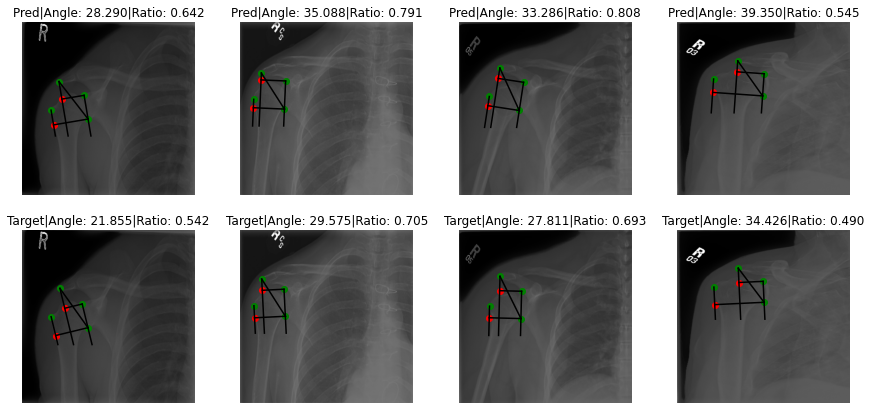

In [15]:
inspect_idxs = [91, 55, 23, 36, 11, 9, 92, 28, 0, 64][:4]
inspect_df = predictions.iloc[inspect_idxs]
paths = [f"./dataset/AP/valid/{path}" for path in inspect_df['#filename'].values]
pred_inspect_coords = pred_coords[inspect_idxs]
target_inspect_coords = target_coords[inspect_idxs]


fig, axes = plt.subplots(2, 4, figsize=(15, 7))
axes = axes.flatten()
for i, (path, pred, target) in enumerate(zip(paths, pred_inspect_coords, target_inspect_coords)):
    angle, ratio, _ = show_angle_ratio(path, size=512, points=pred, ax=axes[i], angle=True, verbose=False, return_values=True)
    axes[i].set_title(f"Pred|Angle: {angle:.3f}|Ratio: {ratio:.3f}")
    axes[i].axis("off")
    angle, ratio, _ = show_angle_ratio(path, size=512, points=target, ax=axes[i + 4], angle=True, verbose=False, return_values=True)
    axes[i + 4].set_title(f"Target|Angle: {angle:.3f}|Ratio: {ratio:.3f}")
    axes[i + 4].axis("off")

# fig.savefig("pred_vs_target.png", facecolor="white")

In [16]:
all_results.to_csv("results/all_results.csv", index=False)
all_results.describe().to_excel("results/result_summary.xlsx")

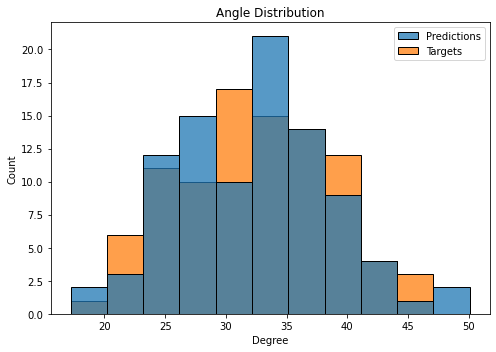

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.histplot(all_results[['pred_angles', 'target_angles']]\
            .rename(columns={'pred_angles': 'Predictions', 'target_angles': 'Targets'}),
             ax=ax)
ax.set_title("Angle Distribution")
ax.set_xlabel("Degree")
plt.tight_layout()
fig.savefig("results/angle_dist.png", facecolor='white')
plt.show()

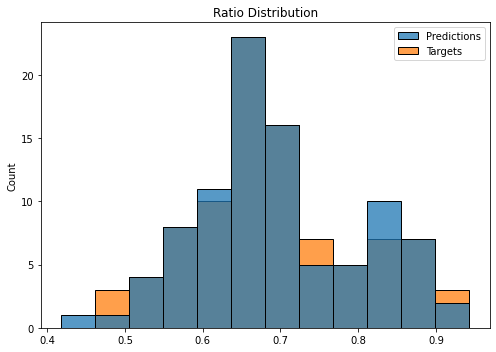

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.histplot(all_results[['pred_ratios', 'target_ratios']]\
            .rename(columns={'pred_ratios': 'Predictions', 'target_ratios': 'Targets'}),
             ax=ax)
ax.set_title("Ratio Distribution")
plt.tight_layout()
fig.savefig("results/ratio_dist.png", facecolor='white')
plt.show()

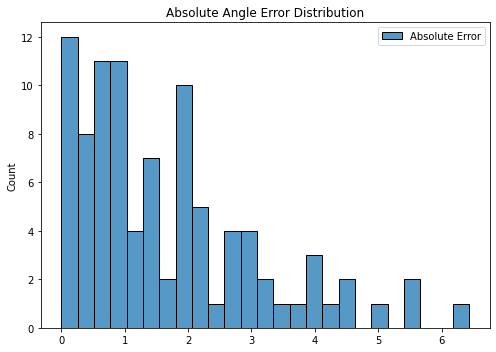

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.histplot(all_results[['angle_error']].abs()\
            .rename(columns={'angle_error': 'Absolute Error'}),
             bins=25,
             ax=ax)
ax.set_title("Absolute Angle Error Distribution")
plt.tight_layout()
fig.savefig("results/angle_error_dist.png", facecolor='white')
plt.show()

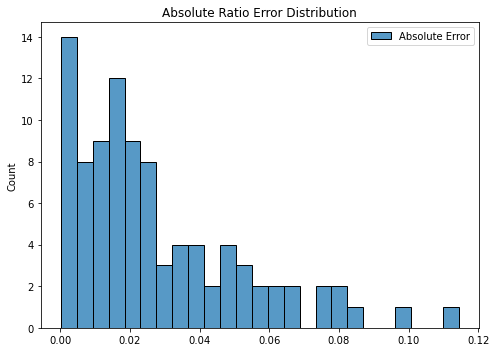

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.histplot(all_results[['ratio_error']].abs()\
            .rename(columns={'ratio_error': 'Absolute Error'}),
             bins=25,
             ax=ax)
ax.set_title("Absolute Ratio Error Distribution")
plt.tight_layout()
fig.savefig("results/ratio_error_dist.png", facecolor='white')
plt.show()

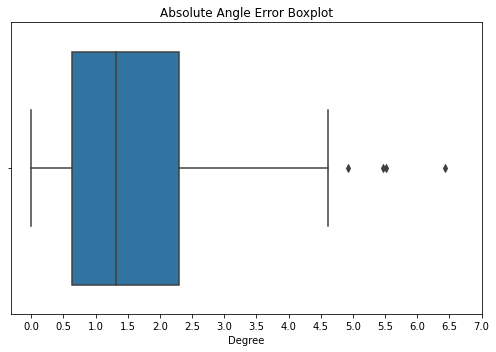

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.boxplot(x=all_results[['angle_error']].abs().values,
            ax=ax)
ax.set_title("Absolute Angle Error Boxplot")
ax.set_xticks(np.linspace(0, 7, 15))
ax.set_xlabel("Degree")
plt.tight_layout()
fig.savefig("results/angle_error_boxplot.png", facecolor='white')
plt.show()

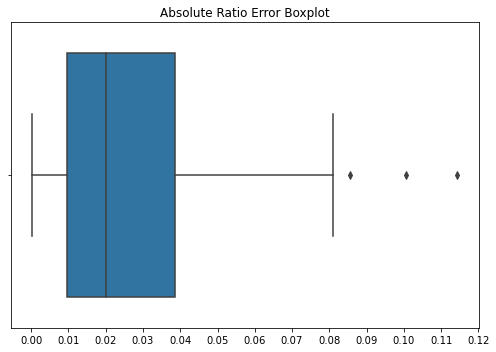

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.boxplot(x=all_results[['ratio_error']].abs().values,
            ax=ax)
ax.set_title("Absolute Ratio Error Boxplot")
ax.set_xticks(np.linspace(0, 0.12, 13))
plt.tight_layout()
fig.savefig("results/ratio_error_boxplot.png", facecolor='white')
plt.show()